In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '안녕하세요',
    '만나다',
    '반갑다'
]

data = np.concatenate([
    np.load('dataset/0_안녕하세요_.npy'),
    np.load('dataset/1_만나다_.npy'),
    np.load('dataset/2_반갑다_.npy'),
], axis=0)

data.shape

(569, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

print('\n수어 인덱스')
idxes = {}
for i in labels:
    if i not in idxes:
        idxes[i] = True
        print(i)

(569, 30, 99)
(569,)

수어 인덱스 목록
0.0
1.0
2.0


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(569, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(512, 30, 99) (512, 3)
(57, 30, 99) (57, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # (512,30,99)[1:3] => (30,99): (시퀀스 길이, 특징 수)
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('model_ko.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
 9/16 [===============>..............] - ETA: 0s - loss: 34.8365 - acc: 0.3194
Epoch 00001: val_acc improved from -inf to 0.73684, saving model to model_ko.h5
16/16 [==============================] - 0s 22ms/step - loss: 25.1133 - acc: 0.4160 - val_loss: 2.6390 - val_acc: 0.7368
Epoch 2/200
 8/16 [==============>...............] - ETA: 0s - loss: 3.4748 - acc: 0.6406
Epoch 00002: val_acc improved from 0.73684 to 0.84211, saving model to model_ko.h5
16/16 [==============================] - 0s 9ms/step - loss: 2.7312 - acc: 0.6641 - val_loss: 2.8895 - val_acc: 0.8421
Epoch 3/200
 9/16 [===============>..............] - ETA: 0s - loss: 2.3733 - acc: 0.8438
Epoch 00003: val_acc improved from 0.84211 to 0.96491, saving model to model_ko.h5
16/16 [==============================] - 0s 7ms/step - loss: 1.9864 - acc: 0.8672 - val_loss: 1.5846 - val_acc: 0.9649
Epoch 4/200
11/16 [===================>..........] - ETA: 0s - loss: 7.4287 - acc: 0.8097
Epoch 00004: val_acc did not impro

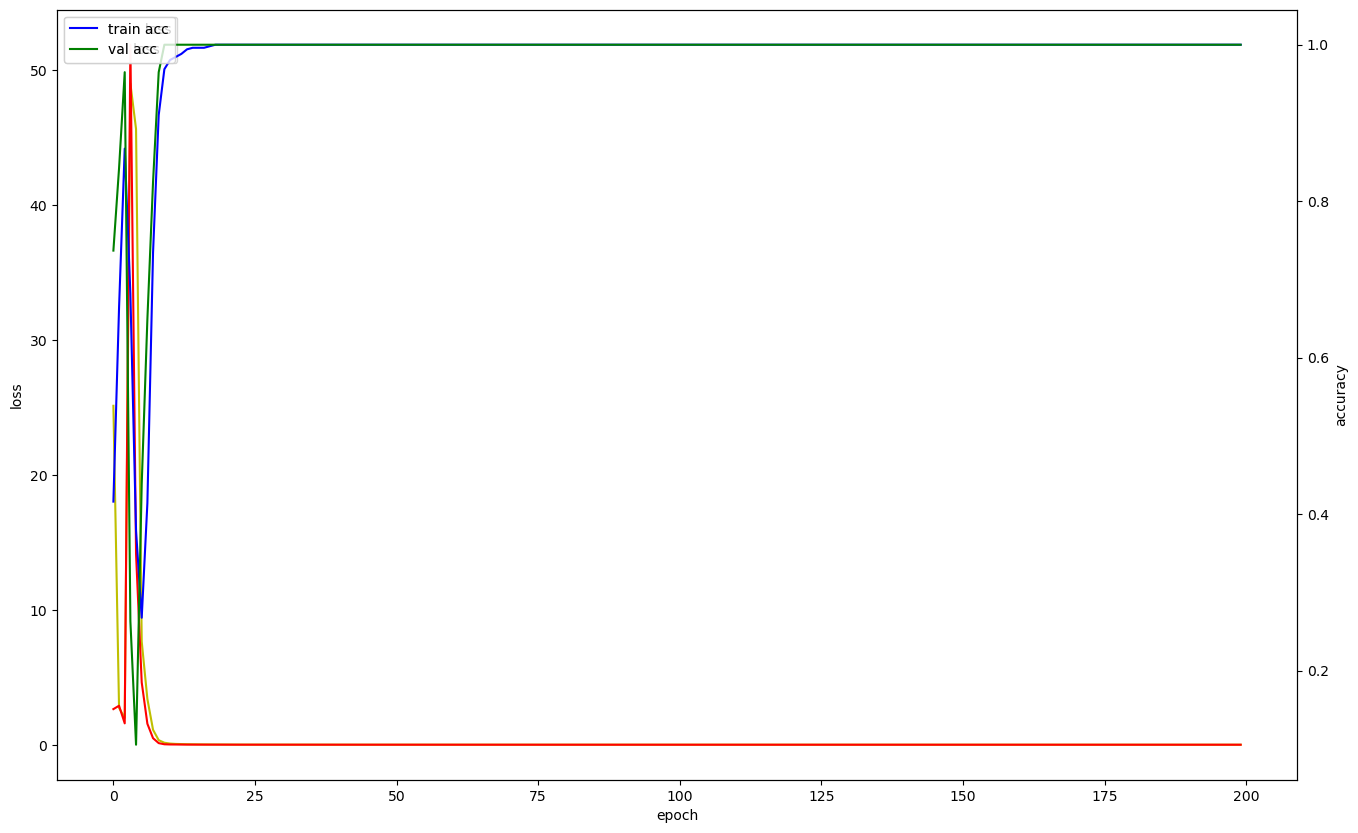

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix


y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[42,  0],
        [ 0, 15]],

       [[31,  0],
        [ 0, 26]],

       [[41,  0],
        [ 0, 16]]], dtype=int64)